<a href="https://colab.research.google.com/github/mnsosa/resistencia-de-materiales/blob/main/EyR_Parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estática y Resistencia de Materiales 

Se dividirán en secciones la práctica de distintos temas.

En algunos temas habrán cosas muy automatizadas, con declaraciones de clases más
completas. En otros, solo se escribirán las ecuaciones para se ahorre tiempo durante
el examen.

Se separarán los datos de los ejercicios en una dataclass con la resolución del ejercicio.

# Tracción y compresión

## Utilidades

Tensión
$$ \sigma = \frac{N}{Ω} $$ 
Deformación
$$ \delta _p = \frac{N*l}{Ω*E} $$
Alargamiento unitario
$$ ϵ = \frac{\delta}{l} = \frac {\sigma}{E} $$
Dilatación térmica
$$ δ_t = \alpha*L*\Delta T $$

Tensión generada por deformación con holgura δ_d
$$ \sigma = δ_d \frac{E}{l} - \alpha E \Delta T $$

In [162]:
from dataclasses import dataclass, field
from typing import Optional, List
from numpy import pi, sqrt
import numpy as np

# RECORDAR REVISAR ESTO EN CADA EJERCICIO
# A veces redondean distinto las constantes

# CONSTANTES
E_ACERO = 2100000 # kg/cm2 
ALFA_ACERO = 125 *10**(-7) # 1/°C
SIGMA_ADM_ACERO = 1400 # kg/cm2

E_COBRE = 1.1*10**6 # kg/cm2
ALFA_COBRE = 1.6*10**(-5) # 1/°C

# Ecuaciones bases
def tension_normal(N, A): return N/A
def deformacion_p(N, L, A, E): return N*L/(A*E)
def deformacion_t(alfa, L, deltaT): return alfa*L*deltaT 
#------------------------------------------------------

@dataclass
class tracc_compresion:
  # Se inicializa con los datos del problema
  normal: float = None
  area: float = None 
  largo: float = None

  deformacion: float = 0
  diam_externo: float = None
  diam_interno: float = None

  sigma_adm: float = None
  deformacion_adm: float = None
  E: float = None

  unidad_long: str = "cm"
  unidad_tension: str = "kg"

  # Para ejercicios con tramos
  largo_tramos: List[float] = field(default_factory=list)
  area_tramos: List[float] = field(default_factory=list)
  E_tramos: List[float] = field(default_factory=list)
  normal_tramos: List[float] = field(default_factory=list)


  def calcular_tension(self):
    normal = self.normal
    area = self.area

    tension = normal/area
    print(f"La tensión es de {tension} {self.unidad_tension}/{self.unidad_long}^2")
    return tension


  def calcular_deformacion(self):
    normal = self.normal
    largo = self.largo
    area = self.area 
    E = self.E

    deformacion = (normal*largo)/(area*E)
    print(f"La deformación es de {deformacion} {self.unidad_long}")
    return deformacion


  def calcular_deformacion_por_tramos(self):
    """Calcula desde abajo hacia arriba los tramos"""
    N = self.normal_tramos
    L = self.largo_tramos
    A = self.area_tramos
    E = self.E_tramos

    deformacion_total = 0
    for i in range(len(N)):
      print(f"Deformacion p en tramo {i+1}: {N[i]*L[i]/(A[i]*E[i])} {self.unidad_long}")
      deformacion_total += N[i]*L[i]/(A[i]*E[i])
    
    print("Deformación total =", deformacion_total)
    return deformacion_total


  def calcular_diam_externo(self):
    diam_interno = self.diam_interno
    area = self.area

    diam_externo = sqrt(diam_interno**2 + area*4/pi)
    print(f"El diametro externo calculado es de {diam_externo} {self.unidad_long}")
    return diam_externo


  def calcular_diam_interno(self):
    diam_externo = self.diam_externo
    area = self.area

    diam_interno = sqrt(diam_externo**2 - area*4/pi)
    print(f"El diametro interno calculado es de {diam_interno} {self.unidad_long}")
    return diam_interno
  

  def calcular_area_por_diametros(self):
    """Si es macizo, poner diam_interno = 0"""
    diam_externo = self.diam_externo
    diam_interno = self.diam_interno

    area = pi/4*(diam_externo**2 - diam_interno**2)
    print(f"El area por los diametros es de {area} {self.unidad_long}^2")
    return area


  def calcular_area_por_tension_adm(self):
    """Dimensionar el área por tensión admisible"""
    sigma_adm = self.sigma_adm
    normal = self.normal

    area = normal/sigma_adm
    area_por_tension = area
    print(f"El area por dimensionamiento por tensión es de {area} {self.unidad_long}^2")
    return area


  def calcular_area_por_deformacion_adm(self):
    """Dimensionar por deformación admnisible"""
    normal = self.normal
    largo = self.largo
    deformacion_adm = self.deformacion_adm
    E = self.E

    area = normal*largo/(deformacion_adm*E)
    self.area_por_deformacion = area
    print(f"El area por dimensionamiento por deformación es de {area} {self.unidad_long}^2")
    return area


  def verificacion_area_por_tension(self):
    """Una vez calculada el area por deformacion, se checkea por tension"""
    sigma_adm = self.sigma_adm
    normal = self.normal
    area_def = self.area_por_deformacion

    verifica_por_tension = (normal/area_def <= sigma_adm)
    print(f"Verificación por tensión: {normal/area_def} <= {sigma_adm}")
    if not verifica_por_tension:
      print("No verifica tensión. Se debe redimensionar por tensión")
      self.area = self.calcular_area_por_tension_adm()
    else:
      print("Verifica por tensión.")
      self.area = self.area_por_deformacion


@dataclass
class efectos_termicos(tracc_compresion):
  """Tipo de problema de tracción compresión que incluye la dilatación térmica"""

  dilatacion: float = None
  alfa: float = None
  deltaT: float = None


  def calcular_dilatacion_termica(self):
    self.dilatacion = self.alfa*self.deltaT*self.largo
    print(f"La dilatación térmica es de {self.dilatacion}")
    return self.dilatacion    
    

@dataclass
class piezas_con_holgura(efectos_termicos):
  """Tipo de problema donde se deja un espacio entre dos piezas que están por dilatarse"""
  holgura: float = None
  alfa_tramos: List[float] = field(default_factory=list)


  def calcular_tension_generada_por_dilatacion(self):
    # Si no estamos hablando de materiales distintos
    holgura = self.holgura
    E = self.E
    alfa = self.alfa
    deltaT = self.deltaT
    L = self.largo

    tension_generada = holgura*E/L - alfa*deltaT*E
    print(f"La tensión generada por la dilatación es de {tension_generada} {self.unidad_long}")
    self.tension_generada = tension_generada
    return tension_generada


  def calcular_dilatacion_termica_por_tramos(self):
    holgura = self.holgura
    E = self.E_tramos
    alfa = self.alfa_tramos
    deltaT = self.deltaT
    L = self.largo_tramos

    dilatacion_total = 0
    for i in range(len(alfa)):
      print(f"Dilataciónn en tramo {i+1}: {deformacion_t(alfa[i], L[i], deltaT)} {self.unidad_long}")
      dilatacion_total += deformacion_t(alfa[i], L[i], deltaT)
    
    print("Dilatación total =", dilatacion_total)
    self.deformacion += dilatacion_total
    return dilatacion_total

  
  def calcular_salto_termico_para_que_se_toquen(self):
    """Calcula el salto térmico necesario para que dos piezas se toquen."""
    alfas = self.alfa_tramos
    E_vector = self.E_tramos
    areas = self.area_tramos
    L = self.largo_tramos
    dd = self.holgura

    deltaT = (dd - self.calcular_deformacion_por_tramos())/np.dot(alfas, L)
    print(f"El salto deltaT necesario es de {deltaT}")
    print(f"Con holgura de {dd}")
    return deltaT

## Guía 5-1: Tensiones y deformaciones

### Ejercicio 5-1

Determinar el diámetro interno φi que debe tener la sección recta anular de una
pieza de acero poco esbelta, sometida a compresión por una carga axial de 12t, siendo
σ_adm=1400 kg/cm2 y φ_e=5cm

In [117]:
# Datos en kg y cm
ej_5_1 = tracc_compresion(normal=12000, sigma_adm=1400, diam_externo=5, E=E_ACERO)
print(ej_5_1)
print("\n")

# Resolución
ej_5_1.area = ej_5_1.calcular_area_por_tension_adm()

ej_5_1.calcular_diam_interno();

tracc_compresion(normal=12000, area=None, largo=None, deformacion=None, diam_externo=5, diam_interno=None, sigma_adm=1400, deformacion_adm=None, E=2100000, unidad_long='cm', unidad_tension='kg', largo_tramos=[], area_tramos=[], E_tramos=[], normal_tramos=[])


El area por dimensionamiento por tensión es de 8.571428571428571 cm^2
El diametro interno calculado es de 3.7532010588275604 cm


### Ejercicio 5-2

Un tensor de acero de 1,30m de longitud, debe soportar una carga de 4,6t.

Determinar el alargamiento total y las dimensiones de su sección recta, siendo ésta:

a) - circular

b) - cuadrada

c) - rectangular con h = 2b

σadm = 2400kg/cm2 

E = 2100000kg/cm2

In [52]:
# Datos
ej_5_2 = tracc_compresion(sigma_adm=2400, E=E_ACERO, normal=4600, largo=130)
print(ej_5_2)
print("\n")

# Resolucion
ej_5_2.area = ej_5_2.calcular_area_por_tension_adm()
ej_5_2.diam_interno = 0
ej_5_2.calcular_diam_externo()
ej_5_2.calcular_deformacion();

tracc_compresion(normal=4600, area=None, largo=130, deformacion=None, diam_externo=None, diam_interno=None, sigma_adm=2400, E=2100000, unidad_long='cm', unidad_tension='kg')


El area por dimensionamiento por tensión es de 1.9166666666666667 cm^2
El diametro externo calculado es de 1.5621702193025344 cm
La deformación es de 0.14857142857142858 cm


### Ejercicio 5-3

Una barra de acero de sección circular de 2,20m de longitud, está sometida a
una carga de tracción de 12t. Siendo el máximo alargamiento permitido δ=0,16cm, determinar
el diámetro de la barra. 

Datos

σadm=1400 kg/cm2 

E=2100000 kg/cm2

In [74]:
# Datos
ej_5_3 = tracc_compresion(largo=220, normal=12000, deformacion_adm=0.16, E=E_ACERO, sigma_adm=1400)
print(ej_5_3, "\n\n")

# Resolución
ej_5_3.calcular_area_por_deformacion_adm()
ej_5_3.verificacion_area_por_tension()
ej_5_3.diam_interno = 0 # Es macizo 
ej_5_3.calcular_diam_externo();

tracc_compresion(normal=12000, area=None, largo=220, deformacion=None, diam_externo=None, diam_interno=None, sigma_adm=1400, deformacion_adm=0.16, E=2100000, unidad_long='cm', unidad_tension='kg') 


El area por dimensionamiento por deformación es de 7.857142857142857 cm^2
Verificación por tensión: 1527.2727272727273 <= 1400
No verifica tensión. Se debe redimensionar por tensión
El area por dimensionamiento por tensión es de 8.571428571428571 cm^2
El diametro externo calculado es de 3.3035559344463477 cm


### Ejercicio 5-4

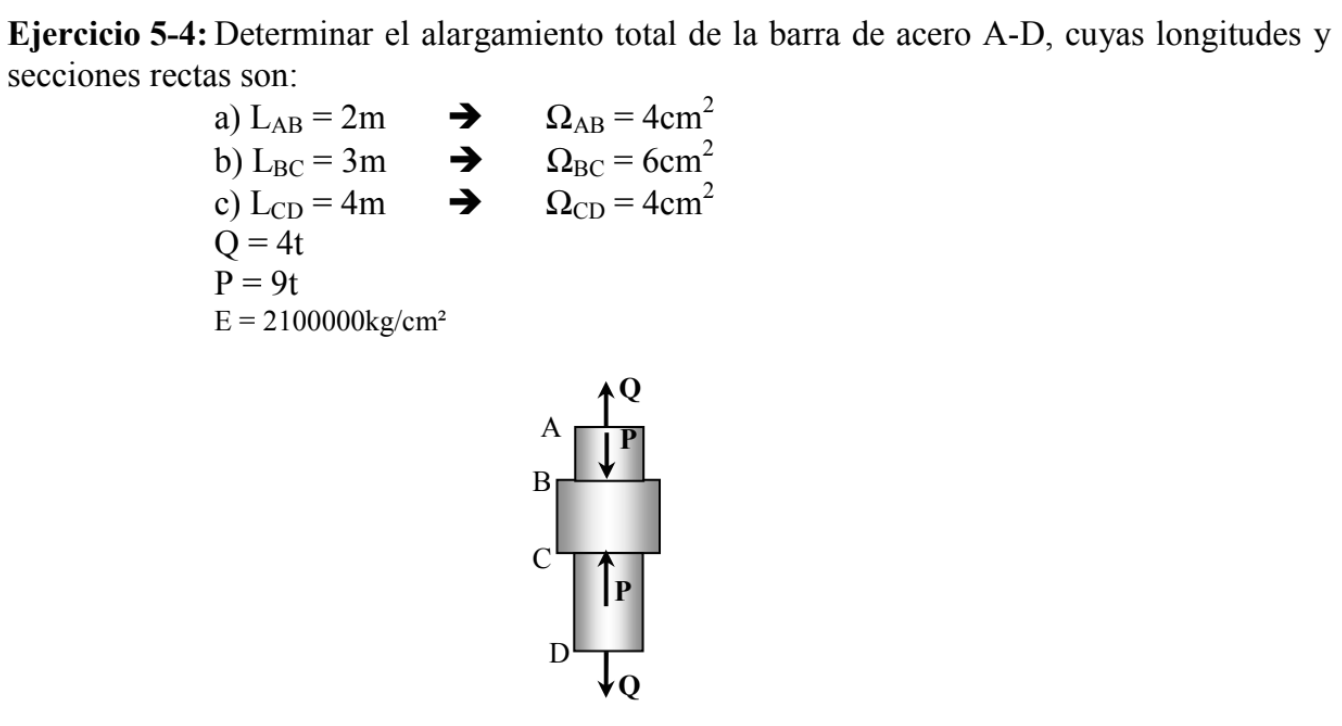

In [104]:
# Datos
ej_5_4 = tracc_compresion(normal_tramos=[9000, 5000, 9000], 
                          area_tramos=[4, 6, 4],
                          largo_tramos=[400, 300, 200],
                          E_tramos=[E_ACERO, E_ACERO, E_ACERO])

print(ej_5_4, "\n\n")

# Resolución
ej_5_4.calcular_deformacion_por_tramos();

tracc_compresion(normal=None, area=None, largo=None, deformacion=None, dilatacion=None, alfa=None, deltaT=None, diam_externo=None, diam_interno=None, sigma_adm=None, deformacion_adm=None, E=None, unidad_long='cm', unidad_tension='kg', largo_tramos=[400, 300, 200], area_tramos=[4, 6, 4], E_tramos=[2100000, 2100000, 2100000], normal_tramos=[9000, 5000, 9000]) 


Tramo 1: 0.42857142857142855
Tramo 2: 0.11904761904761904
Tramo 3: 0.21428571428571427
Deformación total = 0.7619047619047619


## Guía 5-2: Efectos térmicos

### Ejercicio 5-6

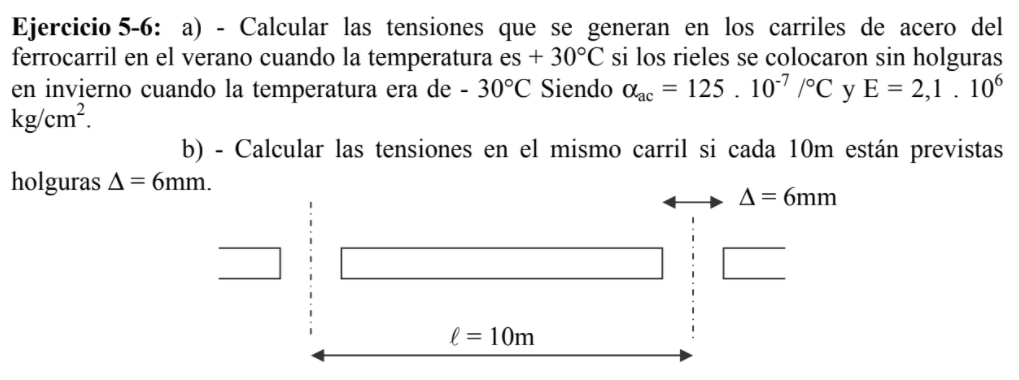

In [115]:
# Datos
ej_5_6 = piezas_con_holgura(deltaT=60, holgura=0, alfa=ALFA_ACERO, E=E_ACERO, largo=1000)

# Resolucion
ej_5_6.calcular_tension_generada_por_dilatacion()

# Segunda parte, con holgura = 0.6
ej_5_6.holgura = 0.6

# Resolución
ej_5_6.calcular_tension_generada_por_dilatacion()
ej_5_6.calcular_dilatacion_termica();

La tensión generada por la dilatación es de -1574.9999999999998 cm
La tensión generada por la dilatación es de -314.9999999999998 cm
La dilatación térmica es de 0.7499999999999999


### Ejercicio 5-7

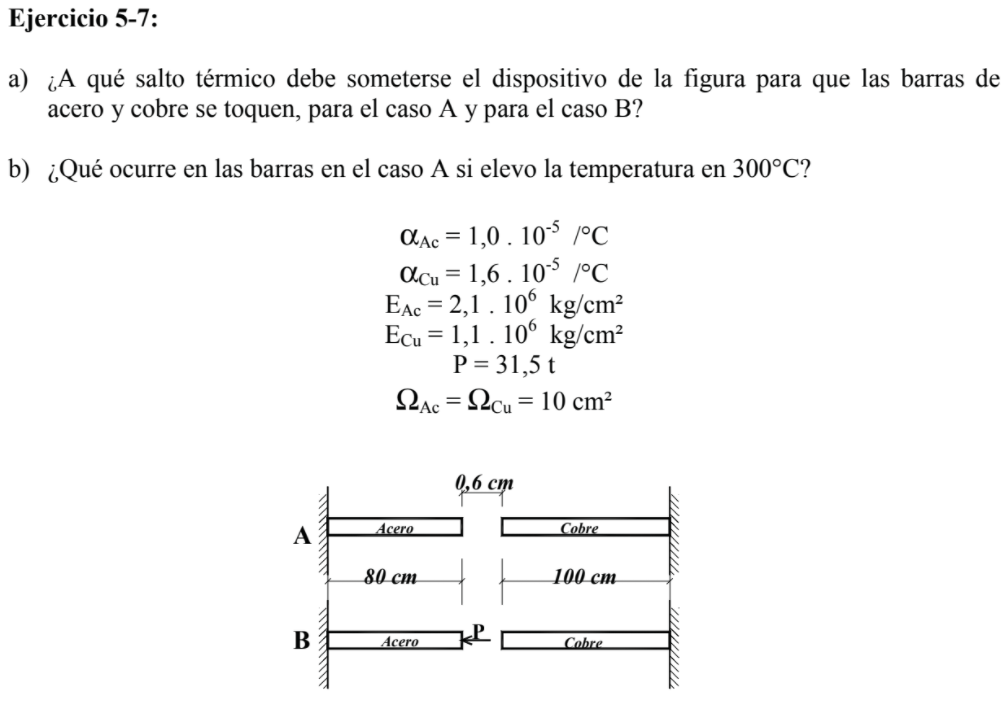

In [164]:
# Datos
"""
  NOTAR QUE EN ESTE EJERCICIO SE APROXIMA DISTINTO EL ALFA ACERO
  Por lo que se ingresa directamente el valor de 1.0 *10^-5
"""
ej_5_7 = piezas_con_holgura(holgura=0.6, 
                            largo_tramos=[80, 100],
                            alfa_tramos=[1.0*10**(-5), ALFA_COBRE], 
                            E_tramos=[E_ACERO, E_COBRE], 
                            area_tramos=[10, 10])
print(ej_5_7, "\n\n")

# Resolución
print("Caso A")
ej_5_7.calcular_salto_termico_para_que_se_toquen()

# Caso b
print("\nCaso B")
ej_5_7.normal_tramos = [-31500, 0]
ej_5_7.calcular_salto_termico_para_que_se_toquen();

# Parte 2 del ejercicio
# Se eleva la temperatura a 300 C para el caso A (sin P)
print("\nParte 2")
ej_5_7.deltaT = 300
ej_5_7.normal_tramos = [0, 0]
ej_5_7.calcular_deformacion_por_tramos()
ej_5_7.calcular_dilatacion_termica_por_tramos()
ej_5_7.calcular_tension_generada_por_dilatacion()

piezas_con_holgura(normal=None, area=None, largo=None, deformacion=None, diam_externo=None, diam_interno=None, sigma_adm=None, deformacion_adm=None, E=None, unidad_long='cm', unidad_tension='kg', largo_tramos=[80, 100], area_tramos=[10, 10], E_tramos=[2100000, 1100000.0], normal_tramos=[], dilatacion=None, alfa=None, deltaT=None, holgura=0.6, alfa_tramos=[1e-05, 1.6000000000000003e-05]) 


Caso A
Deformación total = 0
El salto deltaT necesario es de 249.99999999999997
Con holgura de 0.6

Caso B
Deformacion p en tramo 1: -0.12 cm
Deformacion p en tramo 2: 0.0 cm
Deformación total = -0.12
El salto deltaT necesario es de 299.99999999999994
Con holgura de 0.6

Parte 2
Deformacion p en tramo 1: 0.0 cm
Deformacion p en tramo 2: 0.0 cm
Deformación total = 0.0
Dilataciónn en tramo 1: 0.24000000000000002 cm
Dilataciónn en tramo 2: 0.4800000000000001 cm
Dilatación total = 0.7200000000000001


TypeError: ignored